In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.metrics import accuracy_score


# Data 

In [2]:
customer_data = pd.read_csv(r"CustomersData_.csv", sep = ';' )

discount_coupon = pd.read_csv(r"Discount_Coupon.csv")

marketing_spend = pd.read_csv(r"Marketing_Spend.csv")

online_sales = pd.read_csv(r"Online_Sales.csv")

tax_amount = pd.read_csv(r"Tax_amount_.csv", sep = ';')

# Online Sales 

In [3]:
# Check for Null Values 
online_sales['Transaction_Date'].isna().sum()

# Transforming Date column 

online_sales['Transaction_Date'] = pd.to_datetime(online_sales['Transaction_Date'])

online_sales["Year"] = online_sales["Transaction_Date"].dt.year

online_sales["Month"] = online_sales["Transaction_Date"].dt.month

online_sales["Month"] = online_sales["Transaction_Date"].dt.strftime("%B")


# calcule the amount purchases for each transaction - revenue per transaction 

online_sales = online_sales[online_sales['Avg_Price'] > 0]
online_sales = online_sales[online_sales['CustomerID'].notnull()]
online_sales['Revenue_per_customer_transaction'] = online_sales['Avg_Price'] * online_sales['Quantity']
online_sales

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Year,Month,Revenue_per_customer_transaction
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,2019,January,153.71
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,2019,January,153.71
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.50,Used,2019,January,2.05
3,17850,16682,2019-01-01,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.50,Not Used,2019,January,87.65
4,17850,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.50,Used,2019,January,16.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52919,14410,48493,2019-12-31,GGOENEBB078899,Nest Cam Indoor Security Camera - USA,Nest-USA,1,121.30,6.50,Clicked,2019,December,121.30
52920,14410,48494,2019-12-31,GGOEGAEB091117,Google Zip Hoodie Black,Apparel,1,48.92,6.50,Used,2019,December,48.92
52921,14410,48495,2019-12-31,GGOENEBQ084699,Nest Learning Thermostat 3rd Gen-USA - White,Nest-USA,1,151.88,6.50,Used,2019,December,151.88
52922,14600,48496,2019-12-31,GGOENEBQ079199,Nest Protect Smoke + CO White Wired Alarm-USA,Nest-USA,5,80.52,6.50,Clicked,2019,December,402.60


In [4]:
# change the names on the month column to have it the same as the online sales month column 

discount_coupon['Month'].unique()

month_mapping = {
    'Jan': 'January',
    'Feb': 'February',
    'Mar': 'March',
    'Apr': 'April',
    'May': 'May',
    'Jun': 'June',
    'Jul': 'July',
    'Aug': 'August',
    'Sep': 'September',
    'Oct': 'October',
    'Nov': 'November',
    'Dec': 'December'
}

for index, row in discount_coupon.iterrows():
    
    discount_coupon.at[index, 'Month'] = month_mapping.get(row['Month'], row['Month'])
    
discount_coupon['Month'].unique()



# to calculate invoice we have to calculate te total purchase amount, we need to apply the discount used by the customer and we have to apply the tax, Merging online_sales with discount_coupon

online_coupon_data = pd.merge(online_sales, discount_coupon, on = ['Month', 'Product_Category'], how = 'left')



# I check why we had this null values, some product category dont have dicounts, so I'll just fill it with no_discount

online_coupon_data.isna().sum()

rows_with_null = online_coupon_data[online_coupon_data.isnull().any(axis=1)]

online_coupon_data['Coupon_Code'].fillna('Not Available',inplace=True)

online_coupon_data['Discount_pct'].fillna(0, inplace=True)



# merge with taxes df 

online_coupon_taxes = pd.merge(online_coupon_data, tax_amount, on=['Product_Category'], how = 'left')

online_coupon_taxes['GST'] = online_coupon_taxes['GST'].str.replace('%', '')

online_coupon_taxes['GST'] = pd.to_numeric(online_coupon_taxes['GST'])

online_coupon_taxes['GST'] = (online_coupon_taxes['GST']/100)



# calculate invoice whe have to make a condition where the coupon discount is only apply if it says used in coupon_status

online_coupon_taxes['Invoice'] = np.where(
    online_coupon_taxes['Coupon_Status'] == 'Used',
    ((online_coupon_taxes['Revenue_per_customer_transaction']) * (1 - online_coupon_taxes['Discount_pct']/100) * (1 + online_coupon_taxes['GST'])) + online_coupon_taxes['Delivery_Charges'],
    ((online_coupon_taxes['Revenue_per_customer_transaction']) * (1 + online_coupon_taxes['GST'])) + online_coupon_taxes['Delivery_Charges']
)




Calculating Total store revenue 

In [5]:
# since the date column is not in date time 
marketing_spend['Date'] = pd.to_datetime(marketing_spend['Date'])
marketing_spend['Month'] = marketing_spend['Date'].dt.strftime("%B")

# Calculate the Revenue, Marketing spend, percentage of marketing spend out of revenue, Tax, percentage of delivery charges by month

marketing_spend['Total_Spend'] = marketing_spend['Offline_Spend'] + marketing_spend['Online_Spend']

x = marketing_spend.groupby('Month')['Total_Spend'].sum().reset_index()
y = online_coupon_taxes.groupby('Month')['Invoice'].sum().reset_index()
z = online_coupon_taxes.groupby('Month')['Discount_pct'].mean().reset_index()
tax = online_coupon_taxes.groupby('Month')['GST'].mean().reset_index()
deli_charg = online_coupon_taxes.groupby('Month')['Delivery_Charges'].sum().reset_index()

# Merge the Dataframes to create one with all the total store

total_store = x.merge(y, on='Month', how='inner')
total_store = total_store.merge(z, on='Month', how='inner')
total_store = total_store.merge(tax, on='Month', how='inner')
total_store = total_store.merge(deli_charg, on='Month', how='inner')

total_store['Market_Spend_%'] = (total_store['Total_Spend']*100)/total_store['Invoice']
total_store['Delivery_Charges_%'] = (total_store['Delivery_Charges']*100)/total_store['Invoice']

total_store.dtypes


Month                  object
Total_Spend           float64
Invoice               float64
Discount_pct          float64
GST                   float64
Delivery_Charges      float64
Market_Spend_%        float64
Delivery_Charges_%    float64
dtype: object

# RFM

In [6]:
online_coupon_taxes.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Year,Month,Revenue_per_customer_transaction,Coupon_Code,Discount_pct,GST,Invoice
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,2019,January,153.71,ELEC10,10.0,0.10,158.6729
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,2019,January,153.71,ELEC10,10.0,0.10,158.6729
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.5,Used,2019,January,2.05,OFF10,10.0,0.10,8.5295
3,17850,16682,2019-01-01,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.5,Not Used,2019,January,87.65,SALE10,10.0,0.18,109.9270
4,17850,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.5,Used,2019,January,16.50,AIO10,10.0,0.18,24.0230


In [7]:
# Frequency: Number of purchases
frequency = online_coupon_taxes.groupby('CustomerID')['Transaction_ID'].nunique().reset_index()
frequency.columns = ['CustomerID', 'Frequency']
frequency
frequency.groupby('CustomerID')['Frequency'].sum().mean()

18.141008174386922

In [8]:
# Monetary: Total purchase amount
monetary = online_coupon_taxes.groupby('CustomerID')['Revenue_per_customer_transaction'].sum().reset_index()
monetary.columns = ['CustomerID', 'Monetary']
monetary

# transaction_revenue = online_coupon_taxes.groupby(['CustomerID','Transaction_ID'])['Revenue_per_customer_transaction'].sum().reset_index()
# monetary = transaction_revenue.groupby('CustomerID')['Revenue_per_customer_transaction'].mean().reset_index()

# monetary.columns = ['CustomerID', 'Monetary']
# monetary

,CustomerID,Monetary
0,12346,30.99
1,12347,13834.90
2,12348,1442.12
3,12350,1360.07
4,12356,1442.47
...,...,...
1463,18259,544.34
1464,18260,2363.05
1465,18269,101.56
1466,18277,298.00


In [9]:
# Recency
current_date = online_coupon_taxes['Transaction_Date'].max()

recency = online_coupon_taxes.groupby('CustomerID').agg({'Transaction_Date': lambda x: (current_date - x.max()).days})

recency = recency.reset_index()

In [10]:
# Merge features do have an RFM df

rfm = frequency.merge(monetary, on='CustomerID')

rfm = rfm.merge(recency[['CustomerID', 'Transaction_Date']], on='CustomerID')

rfm.rename(columns={'Transaction_Date': 'Recency'}, inplace=True)

rfm

,CustomerID,Frequency,Monetary,Recency
0,12346,1,30.99,107
1,12347,31,13834.90,59
2,12348,8,1442.12,73
3,12350,11,1360.07,17
4,12356,13,1442.47,107
...,...,...,...,...
1463,18259,3,544.34,270
1464,18260,19,2363.05,87
1465,18269,2,101.56,194
1466,18277,1,298.00,69


Plotting RFM Variables 

<AxesSubplot:xlabel='Monetary', ylabel='Density'>

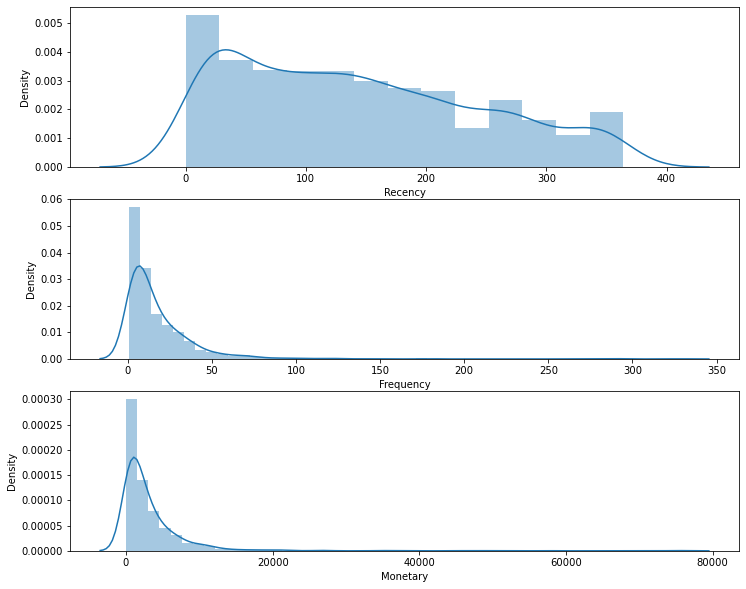

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
# Recency variable distribution 
plt.subplot(3, 1, 1); sns.distplot(rfm['Recency'])
# Frequency variable distribution 
plt.subplot(3, 1, 2); sns.distplot(rfm['Frequency'])
# MonetaryValue variable distribution 
plt.subplot(3, 1, 3); sns.distplot(rfm['Monetary'])

In [12]:
# Setting the index to perform Clustering of the features
rfm.set_index('CustomerID', inplace=True)
rfm


,Frequency,Monetary,Recency
CustomerID,,,
12346,1,30.99,107
12347,31,13834.90,59
12348,8,1442.12,73
12350,11,1360.07,17
12356,13,1442.47,107
...,...,...,...
18259,3,544.34,270
18260,19,2363.05,87
18269,2,101.56,194


In [13]:
rfm_clv = rfm.copy()

# K-Means  - clusters


# CLUSTERS RFM 

In [14]:
# Use of Elbow method to check for the right cluters.
# from sklearn.metrics import silhouette_score
# K = range(2, 20)
# silhouette = []
# for k in K:
#     kmeans = KMeans(n_clusters=k,
#                     random_state=0)
#     kmeans.fit(rfm)
#     silhouette.append(silhouette_score(rfm, kmeans.predict(rfm)))
# plt.figure(figsize=(16,8))
# plt.plot(K, silhouette, 'bx-')
# plt.xlabel('k')
# plt.ylabel('silhouette score')
# plt.xticks(np.arange(min(K), max(K)+1, 1.0))
# plt.title('Elbow Method showing the optimal k')

In [15]:
# Defining the clusters
k = 5


# Apply K-Means clustering 

kmeans = KMeans(n_clusters=k, random_state=0)
rfm['RFM_clusters'] = kmeans.fit_predict(rfm)

rfm

,Frequency,Monetary,Recency,RFM_clusters
CustomerID,,,,
12346,1,30.99,107,2
12347,31,13834.90,59,3
12348,8,1442.12,73,2
12350,11,1360.07,17,2
12356,13,1442.47,107,2
...,...,...,...,...
18259,3,544.34,270,2
18260,19,2363.05,87,2
18269,2,101.56,194,2


In [16]:
# Reset the index to order the clusters 

rfm.reset_index(inplace=True)
rfm.rename(columns={'index': 'CustomerID'}, inplace=True)


In [17]:
# Ordering the clusters function

def order_cluster(cluster_field_name, target_field_names, df, ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_names].mean().reset_index()
    for target_field_name in target_field_names:
        df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
        df_new['index'] = df_new.index
    df_final = pd.merge(df, df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name], axis=1)
    df_final = df_final.rename(columns={"index": cluster_field_name})
    
    return df_final


In [18]:
rfm = order_cluster('RFM_clusters', ['Recency', 'Frequency', 'Monetary'], rfm, True)

In [19]:
# Check to see if the clusters are ok 
rfm.groupby('RFM_clusters')['Recency','Frequency','Monetary'].mean()

,Recency,Frequency,Monetary
RFM_clusters,,,
0,162.281250,7.071121,1016.795528
1,125.286458,25.617188,4378.593594
2,86.937984,51.728682,9819.153023
3,79.681818,96.000000,21649.765455
4,29.200000,289.400000,60572.570000


# Clusters to score for Recency Frequency and Monetary value 

#                    Recency

In [20]:
recency.set_index('CustomerID', inplace=True)
recency

,Transaction_Date
CustomerID,
12346,107
12347,59
12348,73
12350,17
12356,107
...,...
18259,270
18260,87
18269,194


In [21]:
recency.rename(columns={'Transaction_Date': 'Recency'}, inplace=True)
recency

,Recency
CustomerID,
12346,107
12347,59
12348,73
12350,17
12356,107
...,...
18259,270
18260,87
18269,194


In [22]:
# ELbow method to determine the clusters 

# from sklearn.metrics import silhouette_score
# K = range(2, 20)
# silhouette = []
# for k in K:
#     kmeans = KMeans(n_clusters=k,
#                     random_state=0)
#     kmeans.fit(recency)
#     silhouette.append(silhouette_score(recency, kmeans.predict(recency)))
# plt.figure(figsize=(16,8))
# plt.plot(K, silhouette, 'bx-')
# plt.xlabel('k')
# plt.ylabel('silhouette score')
# plt.xticks(np.arange(min(K), max(K)+1, 1.0))
# plt.title('Elbow Method showing the optimal k')

In [23]:
# Clustering with Kmeans 
kmeans_r = KMeans(n_clusters=5)

recency['RecencyCluster'] = kmeans_r.fit_predict(recency)

recency

,Recency,RecencyCluster
CustomerID,,
12346,107,1
12347,59,2
12348,73,1
12350,17,2
12356,107,1
...,...,...
18259,270,0
18260,87,1
18269,194,3


In [24]:
# Setting the index
recency.reset_index(inplace=True)
recency.rename(columns={'index': 'CustomerID'}, inplace=True)
recency

,CustomerID,Recency,RecencyCluster
0,12346,107,1
1,12347,59,2
2,12348,73,1
3,12350,17,2
4,12356,107,1
...,...,...,...
1463,18259,270,0
1464,18260,87,1
1465,18269,194,3
1466,18277,69,2


In [25]:
# Call the function to order the clusters
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    
    return df_final

recency = order_cluster('RecencyCluster', 'Recency', recency, False)

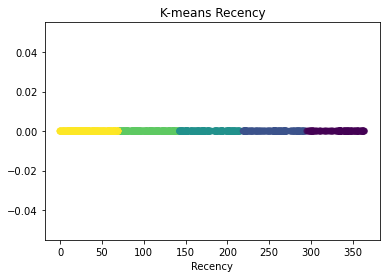

In [26]:
# Plotting the clusters
plt.scatter(recency['Recency'], [0] * len(rfm), c=recency['RecencyCluster'], cmap='viridis', alpha=0.5)
plt.xlabel('Recency')
plt.title('K-means Recency')
plt.show()

In [27]:
# Check to see if the order of th clusters is correct 
recency_cluster_info = recency.groupby('RecencyCluster')['Recency'].describe()
recency_cluster_info

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,149.0,334.456376,19.787890,295.0,320.0,336.0,349.0,364.0
1,225.0,255.324444,22.222225,219.0,235.0,257.0,270.0,293.0
2,299.0,177.581940,21.667154,143.0,158.0,175.0,198.0,216.0
3,347.0,106.789625,20.976290,70.0,88.5,108.0,125.0,142.0
4,448.0,32.111607,19.144010,0.0,17.0,28.0,47.0,69.0


In [28]:
# Merging the recency clusters with the RFM Values 
rfm = rfm.merge(recency[['CustomerID', 'RecencyCluster']], on='CustomerID')
rfm

,CustomerID,Frequency,Monetary,Recency,RFM_clusters,RecencyCluster
0,12346,1,30.99,107,0,3
1,12348,8,1442.12,73,0,3
2,12350,11,1360.07,17,0,4
3,12356,13,1442.47,107,0,3
4,12359,3,601.81,130,0,3
...,...,...,...,...,...,...
1463,12748,328,74601.36,107,4,3
1464,14606,289,57137.79,0,4,4
1465,14911,276,48980.38,10,4,4
1466,15311,291,75937.55,12,4,4


In [29]:
recency.groupby('CustomerID')['Recency'].sum().mean()

144.29223433242507

# Frequency

In [30]:
frequency.set_index('CustomerID', inplace=True)
frequency


,Frequency
CustomerID,
12346,1
12347,31
12348,8
12350,11
12356,13
...,...
18259,3
18260,19
18269,2


In [31]:
# Elbow mwthod to detmine the clusters 

# from sklearn.metrics import silhouette_score
# K = range(2, 20)
# silhouette = []
# for k in K:
#     kmeans = KMeans(n_clusters=k,
#                     random_state=0)
#     kmeans.fit(frequency)
#     silhouette.append(silhouette_score(frequency, kmeans.predict(frequency)))
# plt.figure(figsize=(16,8))
# plt.plot(K, silhouette, 'bx-')
# plt.xlabel('k')
# plt.ylabel('silhouette score')
# plt.xticks(np.arange(min(K), max(K)+1, 1.0))
# plt.title('Elbow Method showing the optimal k')

In [32]:
# K-means to determine frequency clusters 
kmeans_f = KMeans(n_clusters=8)
frequency['FrequencyCluster'] = kmeans_f.fit_predict(frequency)



In [33]:
# Re-setting the index to merge prepare df to merge with rfm 
frequency.reset_index(inplace=True)
frequency.rename(columns={'index': 'CustomerID'}, inplace=True)
frequency

,CustomerID,Frequency,FrequencyCluster
0,12346,1,0
1,12347,31,4
2,12348,8,0
3,12350,11,5
4,12356,13,5
...,...,...,...
1463,18259,3,0
1464,18260,19,5
1465,18269,2,0
1466,18277,1,0


In [34]:
# Call the function to order the clusters
frequency = order_cluster('FrequencyCluster', 'Frequency', frequency, True)

In [35]:
# Check to see if the clusters are ordered
frequency_cluster_info = frequency.groupby('FrequencyCluster')['Frequency'].describe()
frequency_cluster_info

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,620.0,4.183871,2.391773,1.0,2.00,4.0,6.00,8.0
1,406.0,13.369458,3.223594,9.0,10.25,13.0,16.00,19.0
2,249.0,26.574297,4.253497,20.0,23.00,26.0,30.00,34.0
3,118.0,42.305085,5.308449,35.0,38.00,41.0,46.00,54.0
4,52.0,66.269231,8.203575,55.0,58.75,67.0,71.00,85.0
5,14.0,104.785714,12.698750,88.0,95.00,102.0,116.25,124.0
6,4.0,160.000000,19.407902,139.0,145.75,162.0,176.25,177.0
7,5.0,289.400000,24.337214,263.0,276.00,289.0,291.00,328.0


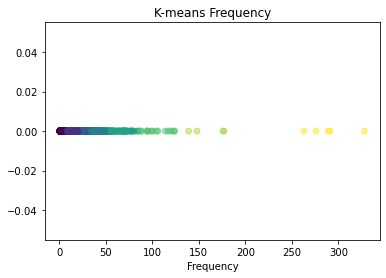

In [36]:
# Plotting the clusters for frequency

plt.scatter(frequency['Frequency'], [0] * len(rfm), c=frequency['FrequencyCluster'], cmap='viridis', alpha=0.5)
plt.xlabel('Frequency')
plt.title('K-means Frequency')
plt.show()

In [37]:
# Merging the clusters with the RFM df 

rfm = rfm.merge(frequency[['CustomerID', 'FrequencyCluster']], on='CustomerID')
rfm

,CustomerID,Frequency,Monetary,Recency,RFM_clusters,RecencyCluster,FrequencyCluster
0,12346,1,30.99,107,0,3,0
1,12348,8,1442.12,73,0,3,0
2,12350,11,1360.07,17,0,4,1
3,12356,13,1442.47,107,0,3,1
4,12359,3,601.81,130,0,3,0
...,...,...,...,...,...,...,...
1463,12748,328,74601.36,107,4,3,7
1464,14606,289,57137.79,0,4,4,7
1465,14911,276,48980.38,10,4,4,7
1466,15311,291,75937.55,12,4,4,7


# Monetary Value

In [38]:
monetary.set_index('CustomerID', inplace=True)
monetary

,Monetary
CustomerID,
12346,30.99
12347,13834.90
12348,1442.12
12350,1360.07
12356,1442.47
...,...
18259,544.34
18260,2363.05
18269,101.56


In [39]:
# Elbow method to determine the amount of clusters 


# from sklearn.metrics import silhouette_score
# K = range(2, 20)
# silhouette = []
# for k in K:
#     kmeans = KMeans(n_clusters=k,
#                     random_state=0)
#     kmeans.fit(monetary)
#     silhouette.append(silhouette_score(monetary, kmeans.predict(monetary)))
# plt.figure(figsize=(16,8))
# plt.plot(K, silhouette, 'bx-')
# plt.xlabel('k')
# plt.ylabel('silhouette score')
# plt.xticks(np.arange(min(K), max(K)+1, 1.0))
# plt.title('Elbow Method showing the optimal k')

In [40]:
#K-means Clusters
kmeans_m = KMeans(n_clusters = 5)
monetary['MonetaryCluster'] = kmeans_m.fit_predict(monetary)

In [41]:
monetary.reset_index(inplace=True)
monetary.rename(columns={'index': 'CustomerID'}, inplace=True)
monetary

,CustomerID,Monetary,MonetaryCluster
0,12346,30.99,3
1,12347,13834.90,2
2,12348,1442.12,3
3,12350,1360.07,3
4,12356,1442.47,3
...,...,...,...
1463,18259,544.34,3
1464,18260,2363.05,3
1465,18269,101.56,3
1466,18277,298.00,3


In [42]:
# Call the function to order the clusters 

monetary = order_cluster('MonetaryCluster', 'Monetary', monetary, True)

In [43]:
#show details of the dataframe

monetary_clusters_info = monetary.groupby('MonetaryCluster')['Monetary'].describe()
monetary_clusters_info

,count,mean,std,min,25%,50%,75%,max
MonetaryCluster,,,,,,,,
0,928.0,1016.795528,760.644223,1.00,346.37,896.115,1609.4700,2684.78
1,383.0,4371.517885,1238.775870,2704.09,3261.68,4137.150,5309.8150,7011.16
2,130.0,9798.148692,2092.604087,7088.59,7979.68,9651.020,11078.5125,15527.65
3,22.0,21649.765455,5429.579096,15960.02,17820.69,20289.425,23126.2925,35574.46
4,5.0,60572.570000,14013.128524,46205.77,48980.38,57137.790,74601.3600,75937.55


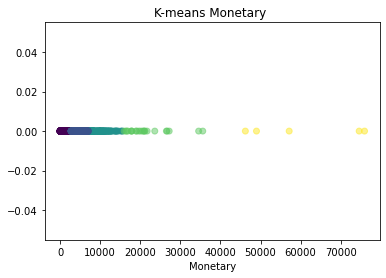

In [44]:
# Plotting the clusters to check the clusters 

plt.scatter(monetary['Monetary'], [0] * len(rfm), c=monetary['MonetaryCluster'], cmap='viridis', alpha=0.5)
plt.xlabel('Monetary')
plt.title('K-means Monetary ')
plt.show()

In [45]:
# MErging the monetary clusters in the rfm ta
rfm = rfm.merge(monetary[['CustomerID', 'MonetaryCluster']], on='CustomerID')
rfm

,CustomerID,Frequency,Monetary,Recency,RFM_clusters,RecencyCluster,FrequencyCluster,MonetaryCluster
0,12346,1,30.99,107,0,3,0,0
1,12348,8,1442.12,73,0,3,0,0
2,12350,11,1360.07,17,0,4,1,0
3,12356,13,1442.47,107,0,3,1,0
4,12359,3,601.81,130,0,3,0,0
...,...,...,...,...,...,...,...,...
1463,12748,328,74601.36,107,4,3,7,4
1464,14606,289,57137.79,0,4,4,7,4
1465,14911,276,48980.38,10,4,4,7,4
1466,15311,291,75937.55,12,4,4,7,4


In [46]:
# # Calculating overall RFM score 

# rfm['RFM_score'] = rfm['RecencyCluster'] * 10 + rfm['FrequencyCluster'] * 10 + rfm['MonetaryCluster']*10

# rfm['RFM_score'].unique()

In [47]:
specific_recency = 0

# Use boolean indexing to filter rows where "Recency" equals the specific value
specific_recency_rows = rfm[rfm['Recency'] == specific_recency]

# Print or inspect the resulting DataFrame
specific_recency_rows

,CustomerID,Frequency,Monetary,Recency,RFM_clusters,RecencyCluster,FrequencyCluster,MonetaryCluster
323,14410,6,1108.99,0,0,4,0,0
330,14438,5,506.88,0,0,4,0,0
361,14600,2,724.68,0,0,4,0,0
533,15781,3,735.29,0,0,4,0,0
1102,12956,14,3002.01,0,1,4,1,1
1464,14606,289,57137.79,0,4,4,7,4


We chose segmentation for four groups. We may interpret them as the following customer segments:

Group 0: Customers who were shopping for a long time, buy moderately often and they shop for high amounts.
Group 1: Customers who have been shopping recently, they buy often and make purchases for large amounts.
Group 2: Customers who have not been buying anything for a long time, they rarely buy and make purchases for relatively small amounts.
Group 3: Customers who have been shopping recently, they rarely buy and make purchases for relatively small amounts.
Based on the received groups we can name them as follows:

Group 0 - former best customers - departing,
Group 1 - best customers - active,
Group 2 - old and random customers - inactive,
Group 3 - new and random customers - new.
Marketing strategies for the customer segments

Based on the 4 clusters, we could formulate marketing strategies relevant to each group:

For the groups 1 and 3 we can apply a typical promotional strategy would focus certain efforts for the high value customers. For the best customers example actions may it be: special offers with discounts, customer cards entitling to benefits (e.g. collecting points redeemed for rewards) or a gift for the next order.

The new clients have not bought from our store before, that's why is worth fighting to transform them into best clients. Example actions for them are: e-mail marketing presenting the advantages of our products, special offers, with discounts for appropriately large purchases.

For the groups 0 and 2 i.e. former best customers and old clients we also can adopt certain marketing strategy. In group 0 (former best clients) include a big customers who for some reason have stopped buying our products, then it is worth trying to renew relations with them hrough an conduct marketing campaign. The group 2 is an old and random customers and here is worth to considering whether we want to carry out some marketing activities.

# LTV

#        LTV - Calculation

In [48]:
cltv_c = online_coupon_taxes.groupby('CustomerID').agg({'Transaction_ID': lambda x: x.nunique(),
                                        'Quantity': lambda x: x.sum(),
                                        'Revenue_per_customer_transaction': lambda x: x.sum()})
cltv_c = pd.DataFrame(cltv_c)

In [49]:
cltv_c.columns = ['Frequency', 'Total_No_Units', 'Monetary']
cltv_c

,Frequency,Total_No_Units,Monetary
CustomerID,,,
12346,1,3,30.99
12347,31,342,13834.90
12348,8,209,1442.12
12350,11,21,1360.07
12356,13,56,1442.47
...,...,...,...
18259,3,46,544.34
18260,19,141,2363.05
18269,2,10,101.56


In [50]:
# Average Order Value 
cltv_c['Avg_Order_Value'] = cltv_c['Monetary']/cltv_c['Frequency']
cltv_c

,Frequency,Total_No_Units,Monetary,Avg_Order_Value
CustomerID,,,,
12346,1,3,30.99,30.990000
12347,31,342,13834.90,446.287097
12348,8,209,1442.12,180.265000
12350,11,21,1360.07,123.642727
12356,13,56,1442.47,110.959231
...,...,...,...,...
18259,3,46,544.34,181.446667
18260,19,141,2363.05,124.371053
18269,2,10,101.56,50.780000


In [51]:
#  Purchase Frequency

cltv_c.shape
OUT =(1468, 8)
cltv_c["Purchase_Frequency"] = cltv_c['Frequency']/cltv_c.shape[0]
cltv_c

,Frequency,Total_No_Units,Monetary,Avg_Order_Value,Purchase_Frequency
CustomerID,,,,,
12346,1,3,30.99,30.990000,0.000681
12347,31,342,13834.90,446.287097,0.021117
12348,8,209,1442.12,180.265000,0.005450
12350,11,21,1360.07,123.642727,0.007493
12356,13,56,1442.47,110.959231,0.008856
...,...,...,...,...,...
18259,3,46,544.34,181.446667,0.002044
18260,19,141,2363.05,124.371053,0.012943
18269,2,10,101.56,50.780000,0.001362


In [52]:
# Churn Rate

repeat_rate = cltv_c[cltv_c.Frequency > 1].shape[0] / cltv_c.shape[0]

cltv_c[cltv_c.Frequency > 1].shape
    
churn_rate = 1 - repeat_rate

In [53]:
cltv_c['Profit_Margin'] = cltv_c['Monetary'] * 0.10

In [54]:
cltv_c['Customer_value'] = (cltv_c['Avg_Order_Value'] * cltv_c["Purchase_Frequency"]) / churn_rate

In [55]:
cltv_c['CLTV'] = round(cltv_c['Customer_value'] * cltv_c['Profit_Margin'], 2)
cltv_c

,Frequency,Total_No_Units,Monetary,Avg_Order_Value,Purchase_Frequency,Profit_Margin,Customer_value,CLTV
CustomerID,,,,,,,,
12346,1,3,30.99,30.990000,0.000681,3.099,0.24792,0.77
12347,31,342,13834.90,446.287097,0.021117,1383.490,110.67920,153123.57
12348,8,209,1442.12,180.265000,0.005450,144.212,11.53696,1663.77
12350,11,21,1360.07,123.642727,0.007493,136.007,10.88056,1479.83
12356,13,56,1442.47,110.959231,0.008856,144.247,11.53976,1664.58
...,...,...,...,...,...,...,...,...
18259,3,46,544.34,181.446667,0.002044,54.434,4.35472,237.04
18260,19,141,2363.05,124.371053,0.012943,236.305,18.90440,4467.20
18269,2,10,101.56,50.780000,0.001362,10.156,0.81248,8.25


In [56]:
cltv_c.reset_index(inplace=True)
cltv_c.rename(columns={'index': 'CustomerID'}, inplace=True)
cltv_c

,CustomerID,Frequency,Total_No_Units,Monetary,Avg_Order_Value,Purchase_Frequency,Profit_Margin,Customer_value,CLTV
0,12346,1,3,30.99,30.990000,0.000681,3.099,0.24792,0.77
1,12347,31,342,13834.90,446.287097,0.021117,1383.490,110.67920,153123.57
2,12348,8,209,1442.12,180.265000,0.005450,144.212,11.53696,1663.77
3,12350,11,21,1360.07,123.642727,0.007493,136.007,10.88056,1479.83
4,12356,13,56,1442.47,110.959231,0.008856,144.247,11.53976,1664.58
...,...,...,...,...,...,...,...,...,...
1463,18259,3,46,544.34,181.446667,0.002044,54.434,4.35472,237.04
1464,18260,19,141,2363.05,124.371053,0.012943,236.305,18.90440,4467.20
1465,18269,2,10,101.56,50.780000,0.001362,10.156,0.81248,8.25
1466,18277,1,2,298.00,298.000000,0.000681,29.800,2.38400,71.04


In [57]:
cltv_merge_rfm = pd.merge(rfm, cltv_c, on='CustomerID', how='inner', suffixes=('', '_y'))
cltv_merge_rfm.drop(cltv_merge_rfm.filter(regex='_y$').columns, axis=1, inplace=True)

cltv_merge_rfm.set_index('CustomerID', inplace=True)
cltv_merge_rfm


,Frequency,Monetary,Recency,RFM_clusters,RecencyCluster,FrequencyCluster,MonetaryCluster,Total_No_Units,Avg_Order_Value,Purchase_Frequency,Profit_Margin,Customer_value,CLTV
CustomerID,,,,,,,,,,,,,
12346,1,30.99,107,0,3,0,0,3,30.990000,0.000681,3.099,0.24792,0.77
12348,8,1442.12,73,0,3,0,0,209,180.265000,0.005450,144.212,11.53696,1663.77
12350,11,1360.07,17,0,4,1,0,21,123.642727,0.007493,136.007,10.88056,1479.83
12356,13,1442.47,107,0,3,1,0,56,110.959231,0.008856,144.247,11.53976,1664.58
12359,3,601.81,130,0,3,0,0,86,200.603333,0.002044,60.181,4.81448,289.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12748,328,74601.36,107,4,3,7,4,4869,227.443171,0.223433,7460.136,596.81088,4452290.33
14606,289,57137.79,0,4,4,7,4,3127,197.708616,0.196866,5713.779,457.10232,2611781.64
14911,276,48980.38,10,4,4,7,4,2232,177.465145,0.188011,4898.038,391.84304,1919262.10


#          LTV - Clustering

In [58]:
# from sklearn.metrics import silhouette_score
# K = range(2, 20)
# silhouette = []
# for k in K:
#     kmeans = KMeans(n_clusters=k,
#                     random_state=0)
#     kmeans.fit(rfm)
#     silhouette.append(silhouette_score(rfm, kmeans.predict(rfm)))
# plt.figure(figsize=(16,8))
# plt.plot(K, silhouette, 'bx-')
# plt.xlabel('k')
# plt.ylabel('silhouette score')
# plt.xticks(np.arange(min(K), max(K)+1, 1.0))
# plt.title('Elbow Method showing the optimal k')

In [59]:
k = 6

# Apply K-Means clustering 
kmeans = KMeans(n_clusters=k, random_state=0)
cltv_merge_rfm['CLTV_Cluster'] = kmeans.fit_predict(cltv_merge_rfm)

cltv_merge_rfm

,Frequency,Monetary,Recency,RFM_clusters,RecencyCluster,FrequencyCluster,MonetaryCluster,Total_No_Units,Avg_Order_Value,Purchase_Frequency,Profit_Margin,Customer_value,CLTV,CLTV_Cluster
CustomerID,,,,,,,,,,,,,,
12346,1,30.99,107,0,3,0,0,3,30.990000,0.000681,3.099,0.24792,0.77,0
12348,8,1442.12,73,0,3,0,0,209,180.265000,0.005450,144.212,11.53696,1663.77,0
12350,11,1360.07,17,0,4,1,0,21,123.642727,0.007493,136.007,10.88056,1479.83,0
12356,13,1442.47,107,0,3,1,0,56,110.959231,0.008856,144.247,11.53976,1664.58,0
12359,3,601.81,130,0,3,0,0,86,200.603333,0.002044,60.181,4.81448,289.74,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12748,328,74601.36,107,4,3,7,4,4869,227.443171,0.223433,7460.136,596.81088,4452290.33,1
14606,289,57137.79,0,4,4,7,4,3127,197.708616,0.196866,5713.779,457.10232,2611781.64,2
14911,276,48980.38,10,4,4,7,4,2232,177.465145,0.188011,4898.038,391.84304,1919262.10,2


In [60]:
cltv_merge_rfm.reset_index(inplace=True)
cltv_merge_rfm.rename(columns={'index': 'CustomerID'}, inplace=True)
cltv_merge_rfm

,CustomerID,Frequency,Monetary,Recency,RFM_clusters,RecencyCluster,FrequencyCluster,MonetaryCluster,Total_No_Units,Avg_Order_Value,Purchase_Frequency,Profit_Margin,Customer_value,CLTV,CLTV_Cluster
0,12346,1,30.99,107,0,3,0,0,3,30.990000,0.000681,3.099,0.24792,0.77,0
1,12348,8,1442.12,73,0,3,0,0,209,180.265000,0.005450,144.212,11.53696,1663.77,0
2,12350,11,1360.07,17,0,4,1,0,21,123.642727,0.007493,136.007,10.88056,1479.83,0
3,12356,13,1442.47,107,0,3,1,0,56,110.959231,0.008856,144.247,11.53976,1664.58,0
4,12359,3,601.81,130,0,3,0,0,86,200.603333,0.002044,60.181,4.81448,289.74,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,12748,328,74601.36,107,4,3,7,4,4869,227.443171,0.223433,7460.136,596.81088,4452290.33,1
1464,14606,289,57137.79,0,4,4,7,4,3127,197.708616,0.196866,5713.779,457.10232,2611781.64,2
1465,14911,276,48980.38,10,4,4,7,4,2232,177.465145,0.188011,4898.038,391.84304,1919262.10,2
1466,15311,291,75937.55,12,4,4,7,4,4211,260.953780,0.198229,7593.755,607.50040,4613209.20,1


In [61]:
# Call the function to order the CLTV clusters 
def order_cluster(cluster_field_name, target_field_names, df, ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_names].mean().reset_index()
    for target_field_name in target_field_names:
        df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
        df_new['index'] = df_new.index
    df_final = pd.merge(df, df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name], axis=1)
    df_final = df_final.rename(columns={"index": cluster_field_name})
    
    return df_final
# Example usage:
cltv_merge_rfm = order_cluster('CLTV_Cluster', ['CLTV'], cltv_merge_rfm, True)

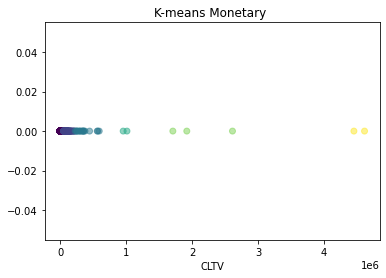

In [62]:
plt.scatter(cltv_merge_rfm['CLTV'], [0] * len(rfm), c=cltv_merge_rfm['CLTV_Cluster'], cmap='viridis', alpha=0.5)
plt.xlabel('CLTV')
plt.title('K-means Monetary ')
plt.show()

In [63]:
cltv_merge_rfm.groupby('CLTV_Cluster')['CLTV'].mean()

CLTV_Cluster
0    6.677452e+03
1    9.534405e+04
2    3.609886e+05
3    9.837366e+05
4    2.079674e+06
5    4.532750e+06
Name: CLTV, dtype: float64

In [62]:
cltv_merge_rfm

,CustomerID,Frequency,Monetary,Recency,RFM_clusters,RecencyCluster,FrequencyCluster,MonetaryCluster,Total_No_Units,Avg_Order_Value,Purchase_Frequency,Profit_Margin,Customer_value,CLTV,CLTV_Cluster
0,12346,1,30.99,107,0,3,0,0,3,30.990000,0.000681,3.099,0.24792,0.77,0
1,12348,8,1442.12,73,0,3,0,0,209,180.265000,0.005450,144.212,11.53696,1663.77,0
2,12350,11,1360.07,17,0,4,1,0,21,123.642727,0.007493,136.007,10.88056,1479.83,0
3,12356,13,1442.47,107,0,3,1,0,56,110.959231,0.008856,144.247,11.53976,1664.58,0
4,12359,3,601.81,130,0,3,0,0,86,200.603333,0.002044,60.181,4.81448,289.74,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,12748,328,74601.36,107,4,3,7,4,4869,227.443171,0.223433,7460.136,596.81088,4452290.33,5
1464,15311,291,75937.55,12,4,4,7,4,4211,260.953780,0.198229,7593.755,607.50040,4613209.20,5
1465,14606,289,57137.79,0,4,4,7,4,3127,197.708616,0.196866,5713.779,457.10232,2611781.64,4
1466,14911,276,48980.38,10,4,4,7,4,2232,177.465145,0.188011,4898.038,391.84304,1919262.10,4


#         LTV Machine Learning Predictions 

In [63]:
cltv_merge_rfm.set_index('CustomerID', inplace=True)
cltv_merge_rfm

,Frequency,Monetary,Recency,RFM_clusters,RecencyCluster,FrequencyCluster,MonetaryCluster,Total_No_Units,Avg_Order_Value,Purchase_Frequency,Profit_Margin,Customer_value,CLTV,CLTV_Cluster
CustomerID,,,,,,,,,,,,,,
12346,1,30.99,107,0,3,0,0,3,30.990000,0.000681,3.099,0.24792,0.77,0
12348,8,1442.12,73,0,3,0,0,209,180.265000,0.005450,144.212,11.53696,1663.77,0
12350,11,1360.07,17,0,4,1,0,21,123.642727,0.007493,136.007,10.88056,1479.83,0
12356,13,1442.47,107,0,3,1,0,56,110.959231,0.008856,144.247,11.53976,1664.58,0
12359,3,601.81,130,0,3,0,0,86,200.603333,0.002044,60.181,4.81448,289.74,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12748,328,74601.36,107,4,3,7,4,4869,227.443171,0.223433,7460.136,596.81088,4452290.33,5
15311,291,75937.55,12,4,4,7,4,4211,260.953780,0.198229,7593.755,607.50040,4613209.20,5
14606,289,57137.79,0,4,4,7,4,3127,197.708616,0.196866,5713.779,457.10232,2611781.64,4


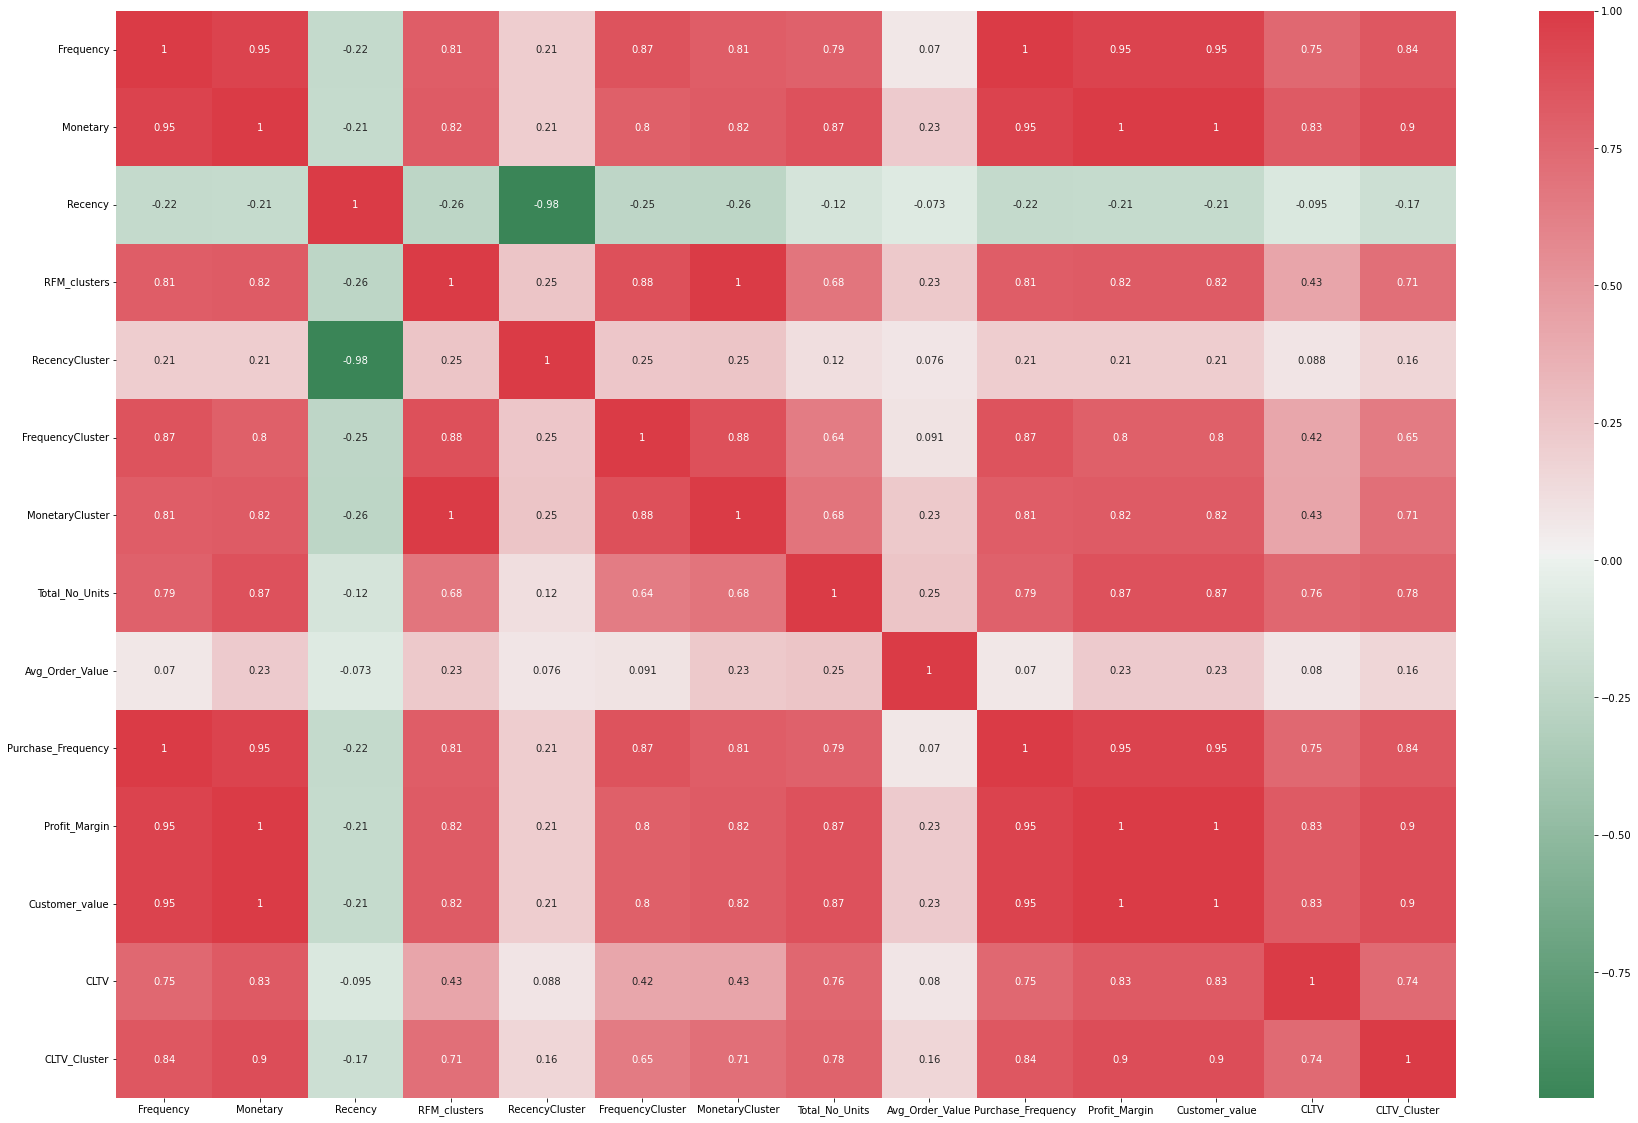

In [64]:
correlations_matrix = cltv_merge_rfm.corr()
cmap = sns.diverging_palette(500, 10, as_cmap=True)
fig, ax = plt.subplots(figsize=(30, 20))
ax = sns.heatmap(correlations_matrix, cmap=cmap, annot=True)
plt.show()

In [65]:
# # Split data into training and testing sets

from sklearn.model_selection import train_test_split
X = cltv_merge_rfm.drop(['CLTV','Avg_Order_Value', 'RecencyCluster', 'Recency', 'Purchase_Frequency', 'Profit_Margin', 'Customer_value', 'MonetaryCluster'], axis=1)
y = cltv_merge_rfm['CLTV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 'Total_No_Units', 'Avg_Order_Value', 'Purchase_Frequency', 'Customer_value','RecencyCluster', 'Recency', 'Profit_Margin', 'CLTV_Cluster', 'RFM_Clusters'

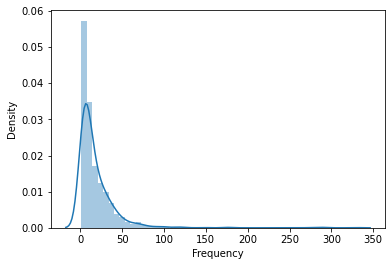

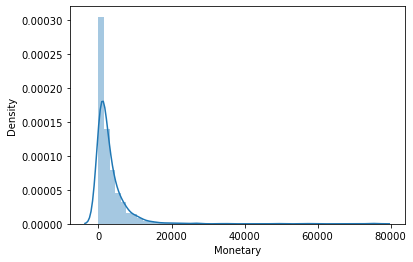

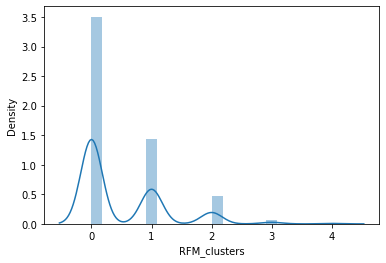

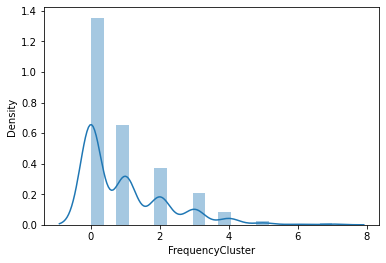

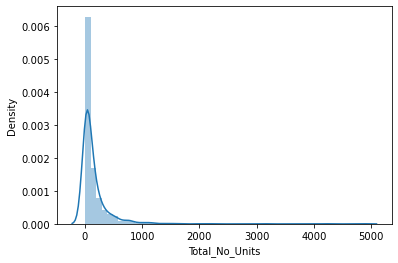

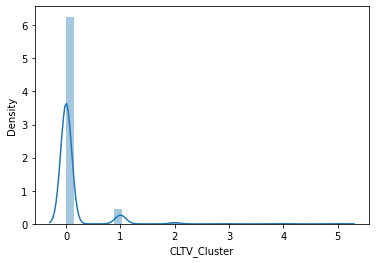

In [67]:
# # from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# standardized_data_RF = scaler.fit_transform(X_train)
# standardized_data_RF = pd.DataFrame(X_train, columns=X_train.columns)
# standardized_data_RF
    
# #plot to check 
# for col in standardized_data_RF.columns:
#     sns.distplot(standardized_data_RF[col])
#     plt.show()

# Random forests

The root mse of the model is =  36788.66554632
R-squared Score: 0.9126560603600143


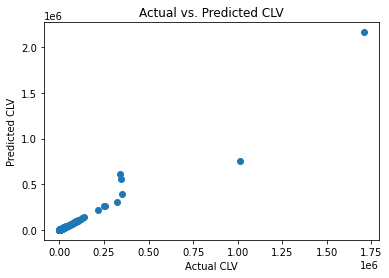

,Actual,Predicted
CustomerID,,
16016,32778.24,32927.6097
13426,517.52,517.3822
16670,9664.95,9694.3558
12727,673.78,672.3390
13700,1318.06,1317.9876
...,...,...
15984,357.16,354.8351
15950,3016.59,3037.8733
16065,42966.94,43121.2992


In [66]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


# Train a simple model (Random Forest Regressor)
RF_model = RandomForestRegressor(n_estimators=100, random_state=42)
RF_model.fit(X_train, y_train)

# Make predictions
Predictions_RF = RF_model.predict(X_test)

# Evaluate the model
mse_RF =np.sqrt(mean_squared_error(y_test, Predictions_RF))
r2_RF = r2_score(y_test, Predictions_RF)

print("The root mse of the model is = ", mse_RF)
print("R-squared Score:", r2_RF)

# Visualize predicted vs. actual CLV
plt.scatter(y_test, Predictions_RF)
plt.xlabel('Actual CLV')
plt.ylabel('Predicted CLV')
plt.title('Actual vs. Predicted CLV')
plt.show()

results_RF = pd.DataFrame({'Actual': y_test, 'Predicted': Predictions_RF})
results_RF

# Gradient Boost

In [67]:
from sklearn.ensemble import HistGradientBoostingRegressor

gb_model = HistGradientBoostingRegressor(max_iter=1000, learning_rate = 0.2, max_depth = 2, min_samples_leaf = 1).fit(X_train, y_train)
gb_model.score(X_train, y_train)
gb_model.score(X_test, y_test)

Predictions_GB = gb_model.predict(X_test)

mse_GB = np.sqrt(mean_squared_error(y_test, Predictions_GB))
r2_GB = r2_score(y_test, Predictions_GB)

print("The root mse of the model is = ", mse_GB)
print("R-squared Score:", r2_GB)

results_GB = pd.DataFrame({'Actual': y_test, 'Predicted': Predictions_GB})
results_GB

The root mse of the model is =  29192.34772561925
R-squared Score: 0.945002524569961


,Actual,Predicted
CustomerID,,
16016,32778.24,32610.084713
13426,517.52,527.180980
16670,9664.95,9501.665700
12727,673.78,604.467422
13700,1318.06,1377.029075
...,...,...
15984,357.16,365.450304
15950,3016.59,2981.051994
16065,42966.94,43206.253171


In [68]:
# from sklearn.model_selection import GridSearchCV
# param_grid = {'max_iter': [500, 1000, 2000], 'learning_rate' : [0.2, 0.3, 0.4],
#     'max_depth': [2,4,6],
#     'min_samples_leaf' : [1, 2]
#     }
# cv_GB = HistGradientBoostingRegressor(random_state=42)

# grid_search = GridSearchCV(cv_GB, param_grid, cv=5,return_train_score=True,n_jobs=-1)
# grid_search.fit(X_train,y_train)
# grid_search.best_params_ #To check the best set of parameters returned

# XGBOOST

In [69]:
# XGBOOSt
import xgboost as xgb

# Initialize XGBoost regressor model
xgb_model = xgb.XGBRegressor(
 max_iter = 1000,
 random_state=42,
 learning_rate = 0.2,
 n_estimators=500,
 max_depth=3,
 objective='reg:squarederror',
 min_samples_leaf = 1)  # You can adjust other hyperparameters here

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
Predictions_XGB = xgb_model.predict(X_test)

# Calculate mean squared error
r2_XGB = r2_score(y_test, Predictions_XGB)
mse_XGB = np.sqrt(mean_squared_error(y_test, Predictions_XGB))


print("R-squared Score:", r2_XGB)
print("The root mse of the model is = ", mse_XGB)

# Create a DataFrame to compare actual vs. predicted values
results_XGB = pd.DataFrame({'Actual': y_test, 'Predicted': Predictions_XGB})
results_XGB

R-squared Score: 0.823341184098477
The root mse of the model is =  52319.70708387632


,Actual,Predicted
CustomerID,,
16016,32778.24,32088.982422
13426,517.52,563.863953
16670,9664.95,9814.919922
12727,673.78,594.119873
13700,1318.06,1241.055054
...,...,...
15984,357.16,406.179138
15950,3016.59,2916.462646
16065,42966.94,42627.242188


In [72]:
# from sklearn.model_selection import GridSearchCV
# param_grid = {'max_iter': [500, 1000, 2000], 'learning_rate' : [0.2, 0.3, 0.4],
#     'max_depth': [2,4,6],
#     'min_samples_leaf' : [1, 2]
#     }
# cv_XGB = xgb.XGBRegressor(random_state=42)

# grid_search = GridSearchCV(cv_XGB, param_grid, cv=5,return_train_score=True,n_jobs=-1)
# grid_search.fit(X_train,y_train)
# grid_search.best_params_ #To check the best set of parameters returne

{'learning_rate': 0.2, 'max_depth': 6, 'max_iter': 500, 'min_samples_leaf': 1}

# ML Models final predictions 

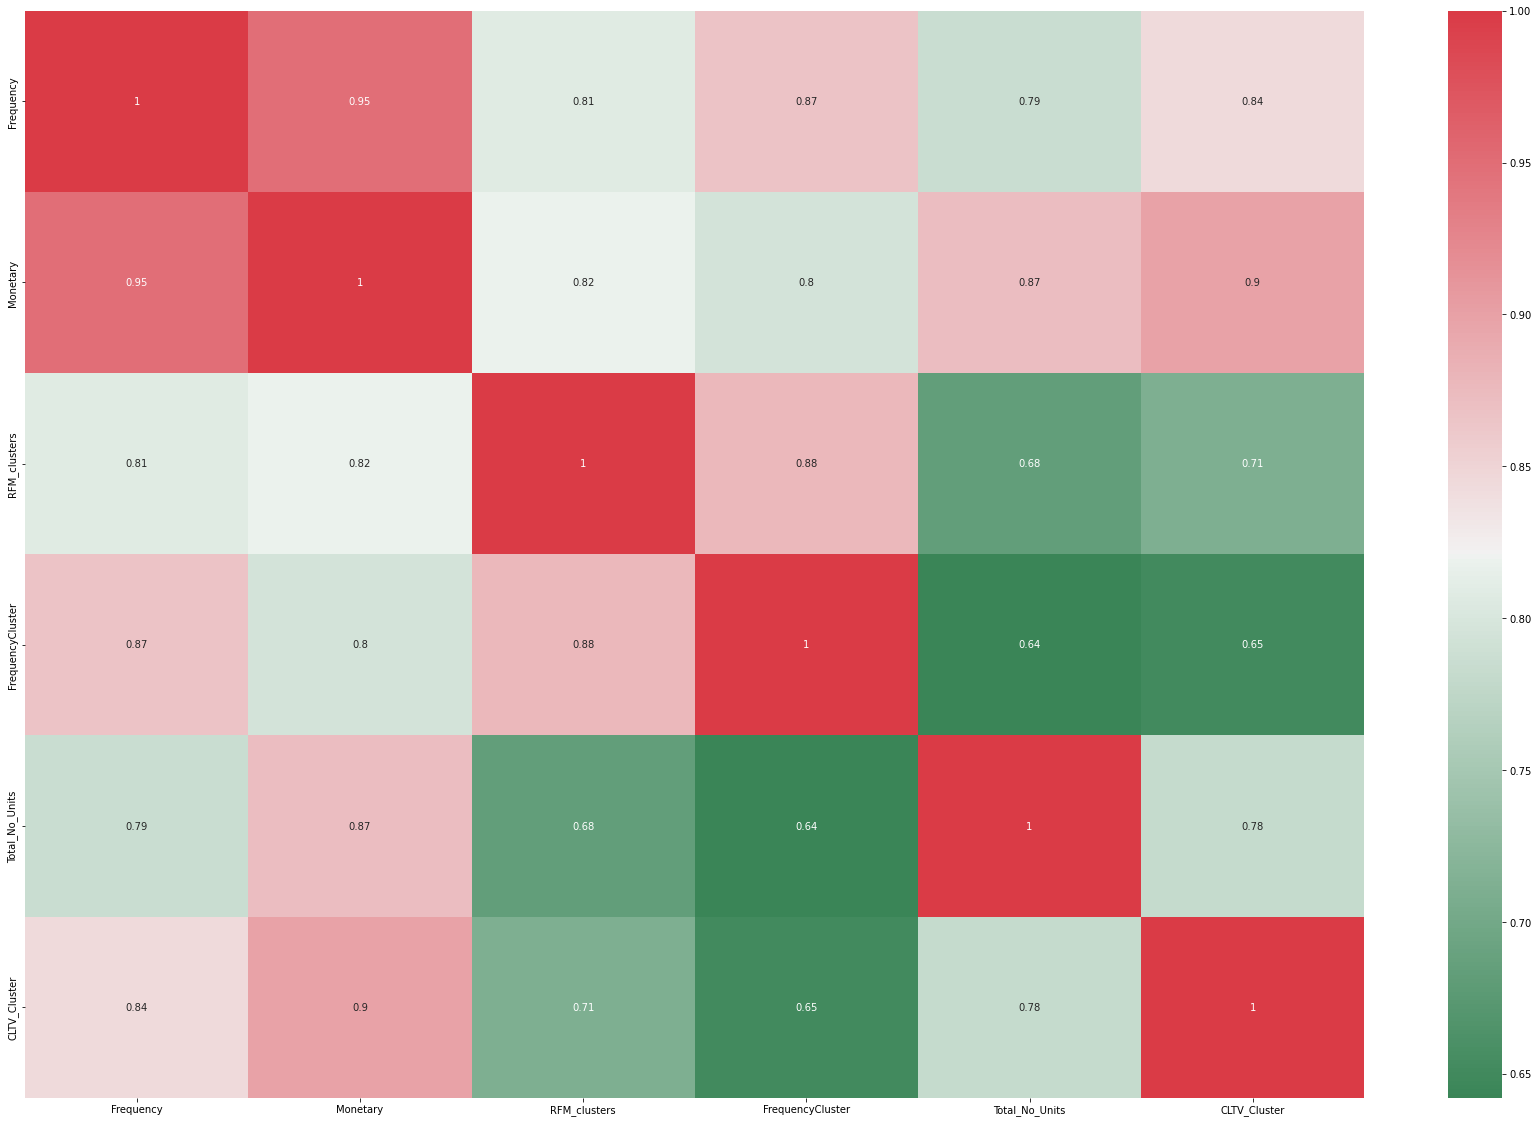

In [70]:
# Correlation matrix
correlations_matrix = X.corr()
cmap = sns.diverging_palette(500, 10, as_cmap=True)
fig, ax = plt.subplots(figsize=(30, 20))
ax = sns.heatmap(correlations_matrix, cmap=cmap, annot=True)
plt.show()

In [74]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# standardized_data = scaler.fit_transform(X_train)
# standardized_data = pd.DataFrame(X_train, columns=X_train.columns)
# standardized_data
    
# #plot to check 
# for col in standardized_data.columns:
#     sns.distplot(standardized_data[col])
#     plt.show()

In [75]:
# After doing the model Testing, I applied the models on the whole data set to have the results of CLTV match the results on rfm dataframe 

# Random Forests

The root mse of the model is =  12756.455220601843
R-squared Score: 0.9959490340496805


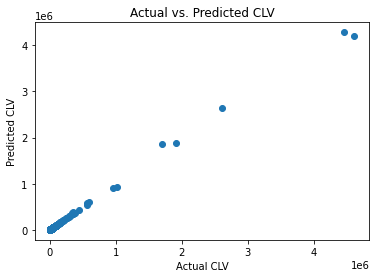

,Predictions_RF
0,0.78
1,1666.49
2,1481.61
3,1666.63
4,290.19
...,...
1463,4281082.22
1464,4198553.30
1465,2638240.23
1466,1883321.84


In [71]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


RF_model = RandomForestRegressor(n_estimators=100, random_state=42)
RF_model.fit(X, y)

# Make predictions
Predictions_RF = RF_model.predict(X)

# Evaluate the model
mse = mean_squared_error(y, Predictions_RF)
r2 = r2_score(y, Predictions_RF)

print("The root mse of the model is = ", np.sqrt(mse))
print("R-squared Score:", r2)

# Visualize predicted vs. actual CLV
plt.scatter(y, Predictions_RF)
plt.xlabel('Actual CLV')
plt.ylabel('Predicted CLV')
plt.title('Actual vs. Predicted CLV')
plt.show()

results_RF = pd.DataFrame({'Predictions_RF': Predictions_RF})
results_RF['Predictions_RF'] = results_RF['Predictions_RF'].round(2)
results_RF


In [77]:
# Grid search for random forests 
# from sklearn.model_selection import GridSearchCV
# param_grid = {'max_iter': [500, 1000, 2000], 'learning_rate' : [0.2, 0.3, 0.4],
#     'max_depth': [2,4,6],
#     'min_samples_leaf' : [1, 2]
#     }
# cv_GB = HistGradientBoostingRegressor(random_state=42)

# grid_search = GridSearchCV(cv_GB, param_grid, cv=5,return_train_score=True,n_jobs=-1)
# grid_search.fit(X_train,y_train)
# grid_search.best_params_ #To check the best set of parameters returned

# Gradient Boost 

In [72]:
from sklearn.ensemble import HistGradientBoostingRegressor

gb_model = HistGradientBoostingRegressor(max_iter=2000, learning_rate = 0.4, max_depth = 2, min_samples_leaf = 2).fit(X, y)
gb_model.score(X, y)


Predictions_GB = gb_model.predict(X)

mse = mean_squared_error(y, Predictions_GB)
r2 = r2_score(y, Predictions_GB)

print("The root mse of the model is = ", np.sqrt(mse))
print("R-squared Score:", r2)

results_GB = pd.DataFrame({'Predictions_GB': Predictions_GB})
results_GB
results_GB['Predictions_GB'] = results_GB['Predictions_GB'].round(2)


The root mse of the model is =  2971.1639110923857
R-squared Score: 0.9997802384053838


In [79]:
# from sklearn.model_selection import GridSearchCV
# param_grid = {'max_iter': [500, 1000, 2000], 'learning_rate' : [0.2, 0.3, 0.4],
#     'max_depth': [2,4,6],
#     'min_samples_leaf' : [1, 2]
#     }
# cv_XGB = xgb.XGBRegressor(random_state=42)

# grid_search = GridSearchCV(cv_GB, param_grid, cv=5,return_train_score=True,n_jobs=-1)
# grid_search.fit(X_train,y_train)
# grid_search.best_params_ #To check the best set of parameters returned

# XG Boost

In [73]:
# XGBOOSt
import xgboost as xgb

# Initialize XGBoost regressor model
xgb_model = xgb.XGBRegressor(
 max_iter = 1000,
 random_state=42,
 learning_rate = 0.2,
 n_estimators=500,
 max_depth=6,
 objective='reg:squarederror',
 min_samples_leaf = 1)  # You can adjust other hyperparameters here

# Train the model
xgb_model.fit(X, y)

# Make predictions
Predictions_XGB = xgb_model.predict(X)

# Calculate mean squared error
r2 = r2_score(y, Predictions_XGB)
mse = mean_squared_error(y, Predictions_XGB)


print("R-squared Score:", r2)
print("The root mse of the model is = ", np.sqrt(mse))

# Create a DataFrame to compare actual vs. predicted values
results_XGB = pd.DataFrame({'Predictions_XGB': Predictions_XGB})

results_XGB['Predictions_XGB'] = results_XGB['Predictions_XGB'].round(2)
results_XGB

R-squared Score: 0.9999999994220988
The root mse of the model is =  4.818118701401338


,Predictions_XGB
0,8.400000e-01
1,1.666290e+03
2,1.472820e+03
3,1.665710e+03
4,2.889800e+02
...,...
1463,4.452293e+06
1464,4.613207e+06
1465,2.611782e+06
1466,1.919262e+06


In [74]:
cltv_merge_rfm.reset_index(inplace=True)
cltv_merge_rfm.rename(columns={'index': 'CustomerID'}, inplace=True)
cltv_merge_rfm

,CustomerID,Frequency,Monetary,Recency,RFM_clusters,RecencyCluster,FrequencyCluster,MonetaryCluster,Total_No_Units,Avg_Order_Value,Purchase_Frequency,Profit_Margin,Customer_value,CLTV,CLTV_Cluster
0,12346,1,30.99,107,0,3,0,0,3,30.990000,0.000681,3.099,0.24792,0.77,0
1,12348,8,1442.12,73,0,3,0,0,209,180.265000,0.005450,144.212,11.53696,1663.77,0
2,12350,11,1360.07,17,0,4,1,0,21,123.642727,0.007493,136.007,10.88056,1479.83,0
3,12356,13,1442.47,107,0,3,1,0,56,110.959231,0.008856,144.247,11.53976,1664.58,0
4,12359,3,601.81,130,0,3,0,0,86,200.603333,0.002044,60.181,4.81448,289.74,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,12748,328,74601.36,107,4,3,7,4,4869,227.443171,0.223433,7460.136,596.81088,4452290.33,5
1464,15311,291,75937.55,12,4,4,7,4,4211,260.953780,0.198229,7593.755,607.50040,4613209.20,5
1465,14606,289,57137.79,0,4,4,7,4,3127,197.708616,0.196866,5713.779,457.10232,2611781.64,4
1466,14911,276,48980.38,10,4,4,7,4,2232,177.465145,0.188011,4898.038,391.84304,1919262.10,4


In [75]:
RFM_CLV_Pred = pd.concat([cltv_merge_rfm, results_RF, results_GB, results_XGB],  axis=1)
RFM_CLV_Pred

,CustomerID,Frequency,Monetary,Recency,RFM_clusters,RecencyCluster,FrequencyCluster,MonetaryCluster,Total_No_Units,Avg_Order_Value,Purchase_Frequency,Profit_Margin,Customer_value,CLTV,CLTV_Cluster,Predictions_RF,Predictions_GB,Predictions_XGB
0,12346,1,30.99,107,0,3,0,0,3,30.990000,0.000681,3.099,0.24792,0.77,0,0.78,1.77,8.400000e-01
1,12348,8,1442.12,73,0,3,0,0,209,180.265000,0.005450,144.212,11.53696,1663.77,0,1666.49,1689.04,1.666290e+03
2,12350,11,1360.07,17,0,4,1,0,21,123.642727,0.007493,136.007,10.88056,1479.83,0,1481.61,1477.11,1.472820e+03
3,12356,13,1442.47,107,0,3,1,0,56,110.959231,0.008856,144.247,11.53976,1664.58,0,1666.63,1675.07,1.665710e+03
4,12359,3,601.81,130,0,3,0,0,86,200.603333,0.002044,60.181,4.81448,289.74,0,290.19,334.37,2.889800e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,12748,328,74601.36,107,4,3,7,4,4869,227.443171,0.223433,7460.136,596.81088,4452290.33,5,4281082.22,4532757.04,4.452293e+06
1464,15311,291,75937.55,12,4,4,7,4,4211,260.953780,0.198229,7593.755,607.50040,4613209.20,5,4198553.30,4532757.04,4.613207e+06
1465,14606,289,57137.79,0,4,4,7,4,3127,197.708616,0.196866,5713.779,457.10232,2611781.64,4,2638240.23,2611737.41,2.611782e+06
1466,14911,276,48980.38,10,4,4,7,4,2232,177.465145,0.188011,4898.038,391.84304,1919262.10,4,1883321.84,1919307.04,1.919262e+06


In [76]:
RFM_CLV_Pred

,CustomerID,Frequency,Monetary,Recency,RFM_clusters,RecencyCluster,FrequencyCluster,MonetaryCluster,Total_No_Units,Avg_Order_Value,Purchase_Frequency,Profit_Margin,Customer_value,CLTV,CLTV_Cluster,Predictions_RF,Predictions_GB,Predictions_XGB
0,12346,1,30.99,107,0,3,0,0,3,30.990000,0.000681,3.099,0.24792,0.77,0,0.78,1.77,8.400000e-01
1,12348,8,1442.12,73,0,3,0,0,209,180.265000,0.005450,144.212,11.53696,1663.77,0,1666.49,1689.04,1.666290e+03
2,12350,11,1360.07,17,0,4,1,0,21,123.642727,0.007493,136.007,10.88056,1479.83,0,1481.61,1477.11,1.472820e+03
3,12356,13,1442.47,107,0,3,1,0,56,110.959231,0.008856,144.247,11.53976,1664.58,0,1666.63,1675.07,1.665710e+03
4,12359,3,601.81,130,0,3,0,0,86,200.603333,0.002044,60.181,4.81448,289.74,0,290.19,334.37,2.889800e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,12748,328,74601.36,107,4,3,7,4,4869,227.443171,0.223433,7460.136,596.81088,4452290.33,5,4281082.22,4532757.04,4.452293e+06
1464,15311,291,75937.55,12,4,4,7,4,4211,260.953780,0.198229,7593.755,607.50040,4613209.20,5,4198553.30,4532757.04,4.613207e+06
1465,14606,289,57137.79,0,4,4,7,4,3127,197.708616,0.196866,5713.779,457.10232,2611781.64,4,2638240.23,2611737.41,2.611782e+06
1466,14911,276,48980.38,10,4,4,7,4,2232,177.465145,0.188011,4898.038,391.84304,1919262.10,4,1883321.84,1919307.04,1.919262e+06


# Save Data in excel files to export to powerbi

In [77]:
# Save the RMSE results 
error_results_RF = pd.DataFrame({'RMSE': mse_RF, 'R2': r2_RF}, index=['Random_Forests'])
error_results_XGB = pd.DataFrame({'RMSE': mse_XGB, 'R2': r2_XGB}, index=['XGBoost'])
error_results_GB = pd.DataFrame({'RMSE': mse_GB, 'R2': r2_GB}, index=['GBoost'])

results = pd.concat([error_results_RF, error_results_XGB, error_results_GB], axis=0)
results.to_excel('results.xlsx', index = True)

In [79]:
online_coupon_taxes.dtypes
online_coupon_taxes['CustomerID'] = online_coupon_taxes['CustomerID'].astype(str)
online_coupon_taxes['Transaction_ID'] = online_coupon_taxes['Transaction_ID'].astype(str)
online_coupon_taxes[['Avg_Price', 'Delivery_Charges', 'Revenue_per_customer_transaction', 'Invoice']] = online_coupon_taxes[['Avg_Price', 'Delivery_Charges', 'Revenue_per_customer_transaction', 'Invoice']].astype(int)
online_coupon_taxes.dtypes

online_coupon_taxes.to_excel('Main_df.xlsx', index=False)

In [78]:
online_coupon_taxes

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Year,Month,Revenue_per_customer_transaction,Coupon_Code,Discount_pct,GST,Invoice
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,2019,January,153.71,ELEC10,10.0,0.10,158.67290
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,2019,January,153.71,ELEC10,10.0,0.10,158.67290
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.50,Used,2019,January,2.05,OFF10,10.0,0.10,8.52950
3,17850,16682,2019-01-01,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.50,Not Used,2019,January,87.65,SALE10,10.0,0.18,109.92700
4,17850,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.50,Used,2019,January,16.50,AIO10,10.0,0.18,24.02300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52919,14410,48493,2019-12-31,GGOENEBB078899,Nest Cam Indoor Security Camera - USA,Nest-USA,1,121.30,6.50,Clicked,2019,December,121.30,ELEC30,30.0,0.10,139.93000
52920,14410,48494,2019-12-31,GGOEGAEB091117,Google Zip Hoodie Black,Apparel,1,48.92,6.50,Used,2019,December,48.92,SALE30,30.0,0.18,46.90792
52921,14410,48495,2019-12-31,GGOENEBQ084699,Nest Learning Thermostat 3rd Gen-USA - White,Nest-USA,1,151.88,6.50,Used,2019,December,151.88,ELEC30,30.0,0.10,123.44760
52922,14600,48496,2019-12-31,GGOENEBQ079199,Nest Protect Smoke + CO White Wired Alarm-USA,Nest-USA,5,80.52,6.50,Clicked,2019,December,402.60,ELEC30,30.0,0.10,449.36000


In [80]:
RFM_CLV_Pred.to_excel('RFM_CLV_Pred.xlsx', index=False)

In [86]:
marketing_spend.to_excel('marketing_spend.xlsx', index=False)